In [43]:
# ===========================
#        Imports
# ===========================
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision import transforms, models
from google.colab import drive
import pandas as pd
import io
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

In [44]:
# ===========================
#    Mount Google Drive
# ===========================
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [45]:
# ===========================
#    Dataset Definition
# ===========================
class ParquetDataset(Dataset):
    def __init__(self, parquet_file_or_df, transform=None):
        """
        Custom Dataset class to load images and genre labels from a Parquet file or DataFrame.

        Parameters:
            parquet_file_or_df (str or pd.DataFrame): Path to the Parquet file or a DataFrame.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        if isinstance(parquet_file_or_df, str):
            # Load from parquet file if a string path is provided
            self.df = pd.read_parquet(parquet_file_or_df)
        elif isinstance(parquet_file_or_df, pd.DataFrame):
            # Use the DataFrame directly if it is provided
            self.df = parquet_file_or_df
        else:
            raise ValueError("parquet_file_or_df must be either a file path (str) or a pandas DataFrame.")

        self.transform = transform

        # Identify genre columns by excluding known columns
        self.non_genre_columns = ['movie_id', 'movie_name', 'movie_poster']
        self.genre_columns = self.df.columns.drop(self.non_genre_columns)
        self.num_genres = len(self.genre_columns)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Retrieves the image and genre labels at the specified index.

        Parameters:
            idx (int): Index of the data point.

        Returns:
            image (Tensor): The transformed image tensor.
            genres (Tensor): The genre labels as a float tensor.
        """
        row = self.df.iloc[idx]

        # Load image from binary data
        image_binary = row['movie_poster']
        image = self.load_image_from_binary(image_binary)

        if self.transform:
            image = self.transform(image)

        # Extract genre labels and convert to tensor
        genres = row[self.genre_columns].values.astype(np.float32)
        genres = torch.from_numpy(genres)

        return image, genres

    @staticmethod
    def load_image_from_binary(image_binary):
        """
        Converts binary image data to a PIL Image.

        Parameters:
            image_binary (bytes): Binary image data.

        Returns:
            image (PIL Image): The loaded image in RGB format.
        """
        img_byte_arr = io.BytesIO(image_binary)
        image = Image.open(img_byte_arr).convert("RGB")
        return image


In [46]:
# ===========================
#    Data Preparation
# ===========================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset_path = '/content/drive/MyDrive/Projects/movie_posters/Training/dataset.parquet'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize dataset
parquet_dataset = ParquetDataset(dataset_path, transform=transform)

# Genre distribution analysis
genre_counts = parquet_dataset.df[parquet_dataset.genre_columns].sum()
print("Genre Counts:\n", genre_counts.sort_values(ascending=False))

# Class weights for imbalanced dataset
class_counts = genre_counts.values
# Add a small epsilon to avoid divide by zero errors
epsilon = 1e-6
# class_weights = 1.0 / (class_counts + epsilon)  # Inverse frequency
# class_weights /= class_weights.sum()  # Normalize class weights to ensure the sum is 1
# class_weights = torch.tensor(class_weights, dtype=torch.float32).to('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate the number of negative samples for each class
neg_counts = len(parquet_dataset) - class_counts

# Compute pos_weight as the ratio of negative to positive samples
class_weights = neg_counts / (class_counts + epsilon)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Handle rare `labels_sum` groups by ensuring at least 2 samples per group
labels_sum = parquet_dataset.df[parquet_dataset.genre_columns].sum(axis=1)

while True:
    rare_labels = labels_sum.value_counts()[labels_sum.value_counts() < 2].index

    if len(rare_labels) == 0:  # Exit loop if no rare groups remain
        break

    # Duplicate samples for rare groups until they have at least 2 samples
    for rare_label in rare_labels:
        rare_samples = parquet_dataset.df[labels_sum == rare_label]
        # Append rare samples to the dataframe until each group has at least 2 samples
        parquet_dataset.df = pd.concat([parquet_dataset.df, rare_samples], ignore_index=True)

    # Recalculate labels_sum after each iteration to ensure all rare labels are handled
    labels_sum = parquet_dataset.df[parquet_dataset.genre_columns].sum(axis=1)

print(f"Dataset length after duplication: {len(parquet_dataset.df)}")

# Recompute `labels_sum` directly from the updated dataset
labels_sum = parquet_dataset.df[parquet_dataset.genre_columns].sum(axis=1)
print(f"Recomputed labels_sum:\n{labels_sum.value_counts()}")  # Verify no group has < 2 samples

# Perform stratified split using the updated DataFrame
from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(
    range(len(parquet_dataset.df)),  # Ensure consistent length with dataset
    test_size=0.2,
    stratify=labels_sum,
    random_state=42
)

# Create Dataset instances from the split DataFrames
train_dataset_df = parquet_dataset.df.iloc[train_idx].reset_index(drop=True)
val_dataset_df = parquet_dataset.df.iloc[val_idx].reset_index(drop=True)

train_dataset = ParquetDataset(train_dataset_df, transform=transform)
val_dataset = ParquetDataset(val_dataset_df, transform=transform)

# Weighted sampler for training
labels_matrix = train_dataset.df[train_dataset.genre_columns].values
sample_weights = np.dot(labels_matrix, class_weights.cpu().numpy())
# Ensure all weights are positive, add epsilon to handle zero weights
sample_weights = np.clip(sample_weights, a_min=epsilon, a_max=None)

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count())

# Debug DataLoader
for images, genres in train_loader:
    print(f"Batch - Images: {images.shape}, Genres: {genres.shape}")
    break


Genre Counts:
 Drama                 765
Thriller              244
Comedy                231
Crime                 201
Action                199
                     ... 
Seinen                  1
Jukebox Musical         1
Bumbling Detective      1
Sketch Comedy           1
Shōjo                   1
Length: 161, dtype: int64
Dataset length after duplication: 995
Recomputed labels_sum:
4     177
5     161
3     139
6     127
2     101
7      94
10     62
8      61
9      39
1      32
12      2
Name: count, dtype: int64
Batch - Images: torch.Size([64, 3, 224, 224]), Genres: torch.Size([64, 161])


In [47]:
# ===========================
#      Model Definition
# ===========================
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        base_model = models.resnet34(pretrained=True)
        self.base = nn.Sequential(*list(base_model.children())[:-1])
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.5),
        )
        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.base(x).flatten(1)
        x = self.fc_layers(x)
        return self.output_layer(x)

model = CustomResNet(num_classes=len(parquet_dataset.genre_columns)).to('cuda' if torch.cuda.is_available() else 'cpu')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
# ===========================
#      Loss and Optimizer
# ===========================
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.0007)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [49]:
print(f"Full dataset length: {len(parquet_dataset)}")
print(f"Train dataset length: {len(train_idx)}, Validation dataset length: {len(val_idx)}")

print(f"Max train index: {max(train_idx)}, Max dataset index: {len(parquet_dataset) - 1}")
print(f"Train indices: {train_idx[:10]}")  # Print a few indices

for images, genres in train_loader:
    print(images.shape, genres.shape)
    break


Full dataset length: 995
Train dataset length: 796, Validation dataset length: 199
Max train index: 994, Max dataset index: 994
Train indices: [112, 597, 787, 560, 817, 287, 705, 358, 57, 869]
torch.Size([64, 3, 224, 224]) torch.Size([64, 161])


In [50]:
# ===========================
#      Training Loop
# ===========================
num_epochs = 30
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize tracking variables for the best model
best_val_loss = float('inf')
best_epoch = -1
checkpoint_path = '/content/drive/MyDrive/Projects/movie_posters/Training/Models/best_model.pth'

train_losses, val_losses = [], []
train_f1_scores, val_f1_scores = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, train_correct, train_total = 0.0, 0, 0
    train_preds, train_labels = [], []
    for images, genres in train_loader:
        images, genres = images.to(device), genres.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, genres)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Predictions and accuracy
        preds = (torch.sigmoid(outputs) > 0.5).int()
        train_correct += (preds == genres).all(dim=1).sum().item()
        train_total += genres.size(0)
        train_preds.append(torch.sigmoid(outputs).detach().cpu())
        train_labels.append(genres.cpu())

    train_preds = torch.cat(train_preds)
    train_labels = torch.cat(train_labels)
    train_f1 = f1_score(train_labels.numpy(), (train_preds.numpy() > 0.5).astype(int), average='samples')
    train_precision = precision_score(train_labels.numpy(), (train_preds.numpy() > 0.5).astype(int), average='samples', zero_division=0)
    train_recall = recall_score(train_labels.numpy(), (train_preds.numpy() > 0.5).astype(int), average='samples')

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_correct / train_total)
    train_f1_scores.append(train_f1)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)

    # Validation
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, genres in val_loader:
            images, genres = images.to(device), genres.to(device)
            outputs = model(images)
            val_running_loss += criterion(outputs, genres).item()

            preds = (torch.sigmoid(outputs) > 0.5).int()
            val_correct += (preds == genres).all(dim=1).sum().item()
            val_total += genres.size(0)
            val_preds.append(torch.sigmoid(outputs).cpu())
            val_labels.append(genres.cpu())

    val_preds = torch.cat(val_preds)
    val_labels = torch.cat(val_labels)
    val_f1 = f1_score(val_labels.numpy(), (val_preds.numpy() > 0.5).astype(int), average='samples')
    val_precision = precision_score(val_labels.numpy(), (val_preds.numpy() > 0.5).astype(int), average='samples', zero_division=0)
    val_recall = recall_score(val_labels.numpy(), (val_preds.numpy() > 0.5).astype(int), average='samples')

    val_losses.append(val_running_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)
    val_f1_scores.append(val_f1)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

    # Scheduler step
    scheduler.step(val_losses[-1])

    # Check if this is the best model so far
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_epoch = epoch + 1
        torch.save(model, checkpoint_path)
        print(f"✅ Saved Best Model at Epoch {epoch+1} with Validation Loss: {best_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Val Acc: {val_accuracies[-1]:.4f}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")

print(f"Training Complete! Best Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch}")


✅ Saved Best Model at Epoch 1 with Validation Loss: 1.3861
Epoch [2/30] - Train Loss: 2.3461, Val Loss: 1.4565, Train Acc: 0.0000, Val Acc: 0.0000, Train F1: 0.0867, Val F1: 0.0420
Epoch [3/30] - Train Loss: 2.0731, Val Loss: 1.7698, Train Acc: 0.0000, Val Acc: 0.0000, Train F1: 0.0768, Val F1: 0.0364
Epoch [4/30] - Train Loss: 1.9461, Val Loss: 1.5060, Train Acc: 0.0000, Val Acc: 0.0000, Train F1: 0.0783, Val F1: 0.0409
Epoch [5/30] - Train Loss: 1.9114, Val Loss: 1.4474, Train Acc: 0.0000, Val Acc: 0.0000, Train F1: 0.0845, Val F1: 0.0424
Epoch [6/30] - Train Loss: 1.8442, Val Loss: 1.4249, Train Acc: 0.0000, Val Acc: 0.0000, Train F1: 0.0806, Val F1: 0.0430
✅ Saved Best Model at Epoch 7 with Validation Loss: 1.3802
Epoch [8/30] - Train Loss: 1.8077, Val Loss: 1.3952, Train Acc: 0.0000, Val Acc: 0.0000, Train F1: 0.0844, Val F1: 0.0452
Epoch [9/30] - Train Loss: 1.8409, Val Loss: 1.4185, Train Acc: 0.0000, Val Acc: 0.0000, Train F1: 0.0861, Val F1: 0.0461
Epoch [10/30] - Train Loss: 

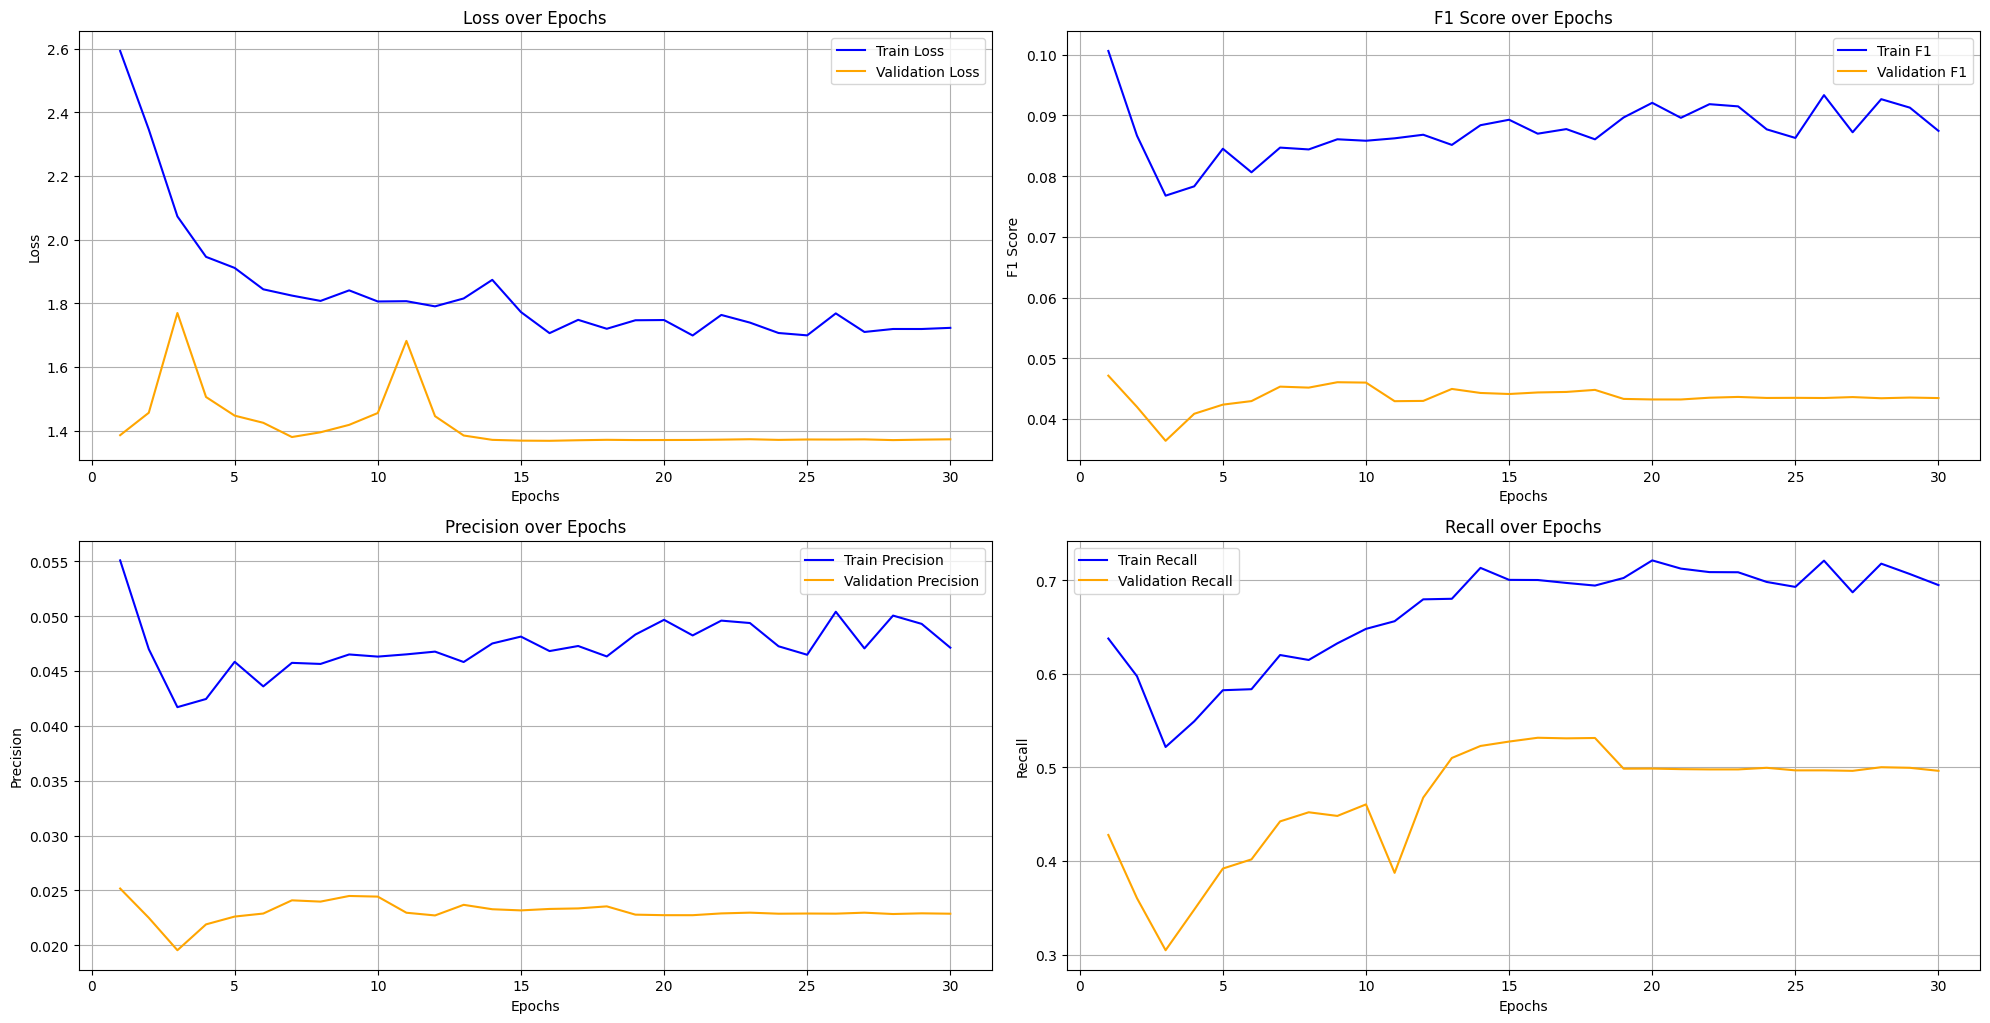

In [52]:
# ===========================
#        Plot Results
# ===========================
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(20, 15))
metrics = [
    ("Train Loss", "Validation Loss", train_losses, val_losses, "Loss"),
    ("Train F1", "Validation F1", train_f1_scores, val_f1_scores, "F1 Score"),
    ("Train Precision", "Validation Precision", train_precisions, val_precisions, "Precision"),
    ("Train Recall", "Validation Recall", train_recalls, val_recalls, "Recall")
]

for i, (train_label, val_label, train_metric, val_metric, title) in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    plt.plot(epochs, train_metric, label=train_label, color='blue')
    plt.plot(epochs, val_metric, label=val_label, color='orange')
    plt.xlabel("Epochs")
    plt.ylabel(title)
    plt.title(f"{title} over Epochs")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()